In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, MaxPooling1D, Flatten
from keras.models import Sequential
import os
from keras.layers import Dense, Activation, LSTM, Dropout
import joblib
# import rc
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# how to use .h5 file
# https://www.tensorflow.org/tutorials/keras/save_and_load


import warnings
warnings.filterwarnings('ignore')

In [41]:
# 모든 데이터를 합친 데이터(정리된 데이터)
data = pd.read_csv('data/merge_all/merge_drop.csv')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래년월일           5782 non-null   object 
 1   자동차용 경유 가격 (원)  5782 non-null   float64
 2   전월비(%)          5782 non-null   float64
 3   평균              5782 non-null   float64
 4   거래량             5782 non-null   float64
dtypes: float64(4), object(1)
memory usage: 226.0+ KB


In [43]:
# 상관관계확인
# print(data.corr(method='kendall'))
# print(data.corr(method='spearman'))
# print(data.corr(method='pearson'))

In [44]:
# "배추가격"의 이동평균을 # 코드를 함수로 만든다. 당일 제외
def make_ma(df, col, ma_list):
    for ma in ma_list:
        df[col + '_' + str(ma) + 'MA'] = df[col].rolling(window=ma).mean().shift(1)
    return df

# "배추가격"의 이동평균을 구한다
data = make_ma(data, '평균', [5, 20, 60, 300])

# # 거래량 컬럼 제거
data = data.drop(['거래량'], axis=1)

# "배추가격_N" 컬럼의 결측치를 제거한다
data = data.dropna()

# 인덱스 정렬하기
data = data.reset_index(drop=True)

# data 를 data_xgb 로 넣기
data_lstm = data

In [54]:
data_lstm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5482 entries, 0 to 5481
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래년월일           5482 non-null   object 
 1   자동차용 경유 가격 (원)  5482 non-null   float64
 2   전월비(%)          5482 non-null   float64
 3   평균              5482 non-null   float64
 4   평균_5MA          5482 non-null   float64
 5   평균_20MA         5482 non-null   float64
 6   평균_60MA         5482 non-null   float64
 7   평균_300MA        5482 non-null   float64
dtypes: float64(7), object(1)
memory usage: 342.8+ KB


In [48]:

data_lstm['거래년월일'][:5460]

0       2001-01-11
1       2001-01-12
2       2001-01-13
3       2001-01-15
4       2001-01-16
           ...    
5455    2022-10-25
5456    2022-10-26
5457    2022-10-27
5458    2022-10-28
5459    2022-10-31
Name: 거래년월일, Length: 5460, dtype: object

In [49]:
# 정규화 작업(date 를 제외한 항목을 제외한 숫자로 표현되는 모든 column에 대해 0~1 값으로 정규화 작업을 수행)
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scale_cols1 = ['자동차용 경유 가격 (원)', '전월비(%)', '평균_5MA', '평균_20MA',	'평균_60MA', '평균_300MA'] #정규화 대상 column 정의
scale_cols2 = ['평균']
scaled_df1 = scaler1.fit_transform(data_lstm[scale_cols1]) # 정규화 수행
print(type(scaled_df1), '\n') # 리턴값 확인하면 numpy.ndarray임을 알 수 있음 -> 데이터프레임으로 변환해서 사용해야함
scaled_df2 = scaler2.fit_transform(data_lstm[scale_cols2]) # 정규화 수행
print(type(scaled_df2), '\n')

# 정규화된 데이터를 데이터프레임으로 변환
scaled_df1 = pd.DataFrame(scaled_df1, columns=scale_cols1) #정규화된 새로운 dataframe 생성
scaled_df2= pd.DataFrame(scaled_df2, columns=scale_cols2) #정규화된 새로운 dataframe 생성
print(scaled_df1)
print(scaled_df2)

<class 'numpy.ndarray'> 

<class 'numpy.ndarray'> 

      자동차용 경유 가격 (원)    전월비(%)    평균_5MA   평균_20MA   평균_60MA  평균_300MA
0           0.050417  0.669967  0.002216  0.000118  0.005566  0.166890
1           0.050417  0.669967  0.002453  0.000000  0.004340  0.165497
2           0.050417  0.669967  0.002807  0.000034  0.003260  0.164104
3           0.050417  0.669967  0.002334  0.000220  0.002340  0.162703
4           0.050417  0.669967  0.002925  0.000710  0.001574  0.161325
...              ...       ...       ...       ...       ...       ...
5477        0.860439  0.135314  0.135715  0.175457  0.748259  0.987292
5478        0.860439  0.135314  0.133753  0.171822  0.739531  0.986339
5479        0.860439  0.135314  0.128328  0.168754  0.726645  0.984891
5480        0.860439  0.135314  0.124569  0.165158  0.712254  0.983326
5481        0.860439  0.135314  0.120622  0.162188  0.697012  0.982506

[5482 rows x 6 columns]
            평균
0     0.003567
1     0.003567
2     0.003567
3     0.007

In [50]:
# 딥러닝 학습을 위한 입력데이터 feature column , 정답데이터 column 정의 후 numpy 로 변환하여 데이터 전처리 과정 완료하기
feature_cols = ['자동차용 경유 가격 (원)', '전월비(%)', '평균_5MA', '평균_20MA', '평균_60MA', '평균_300MA'] #feature 정의(입력데이터)
label_cols = ['평균'] #label 정의(정답데이터)

feature_df = pd.DataFrame(scaled_df1, columns=feature_cols)  #feature 데이터프레임 생성
label_df = pd.DataFrame(scaled_df2, columns=label_cols) #label 데이터프레임 생성

print(feature_df)
print(label_df)

# 딥러닝 학습을 위해 dataframe 에서 numpy 로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

      자동차용 경유 가격 (원)    전월비(%)    평균_5MA   평균_20MA   평균_60MA  평균_300MA
0           0.050417  0.669967  0.002216  0.000118  0.005566  0.166890
1           0.050417  0.669967  0.002453  0.000000  0.004340  0.165497
2           0.050417  0.669967  0.002807  0.000034  0.003260  0.164104
3           0.050417  0.669967  0.002334  0.000220  0.002340  0.162703
4           0.050417  0.669967  0.002925  0.000710  0.001574  0.161325
...              ...       ...       ...       ...       ...       ...
5477        0.860439  0.135314  0.135715  0.175457  0.748259  0.987292
5478        0.860439  0.135314  0.133753  0.171822  0.739531  0.986339
5479        0.860439  0.135314  0.128328  0.168754  0.726645  0.984891
5480        0.860439  0.135314  0.124569  0.165158  0.712254  0.983326
5481        0.860439  0.135314  0.120622  0.162188  0.697012  0.982506

[5482 rows x 6 columns]
            평균
0     0.003567
1     0.003567
2     0.003567
3     0.007452
4     0.010783
...        ...
5477  0.120141
547

In [51]:
# 입력 파라미터 feature, label => numpy type 함수로 만들기 
def make_sequene_dataset(feature, label, window_size):
    feature_list = [] # 생성될 feature list
    label_list = [] # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size]) 
        #feature[i:i+window_size] => 2차원 배열, 슬라이싱 이용하여 [[..], [..],..] 형상으로 입력 데이터, feature를 생성함
        label_list.append(label[i+window_size]) # 2차원 행렬의 배열
    
    return np.array(feature_list), np.array(label_list)  # 3차원 배열로 리턴
    #feature_list = [ [..], [..], ..] 이므로 리턴값 np.array(feature_list)는 (batch_size, time steps, input dims형상을 가짐

In [52]:
# 학습데이터 X, Y 생성
window_size = 20 #앞에 40개 데이터를 이용해서 그 다음 정답데이터 label 를 예측한다는 뜻
X, Y = make_sequene_dataset(feature_np, label_np, window_size) #make_sequence_data 함수를 이용해서 X, Y 생성
print(X.shape, Y.shape)

(5462, 20, 6) (5462, 1)


In [53]:
split = 5460 #(전체 데이터에 *20% ) 트레인 데이터, 테스트 데이터 분리

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5460, 20, 6) (5460, 1)
(2, 20, 6) (2, 1)


In [59]:
model = Sequential()
model.add(LSTM(64, activation='tanh', #LSTM 레이어에서 tanh 를 활성화 함수로 가지는 노드 수 128개
               input_shape=x_train[0].shape)) #input_sape=(40, 2) 40개의 데이터를 2개씩 입력받음
model.add(Dropout(0.3)) #Dropout 레이어에서 30% 노드를 랜덤하게 제거
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [62]:
#모델 컴파일 및 학습
#조기종료 셋팅  : EarlyStopping
#checkpoint 셋팅 : ModelCheckpoint 사용

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae']) #metrics 관찰대상(mae = 평균절대오차값)
early_stop = EarlyStopping(monitor='val_loss', patience=10) #val_loss 가 5번 이상 개선되지 않으면 학습 중단
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, callbacks=[early_stop])

Epoch 1/100
86/86 [==============================] - 22s 68ms/step - loss: 0.0012 - mae: 0.0219 - val_loss: 7.0058e-04 - val_mae: 0.0264
Epoch 2/100
86/86 [==============================] - 7s 78ms/step - loss: 0.0011 - mae: 0.0212 - val_loss: 6.2388e-04 - val_mae: 0.0249
Epoch 3/100
86/86 [==============================] - 3s 40ms/step - loss: 0.0011 - mae: 0.0208 - val_loss: 5.7326e-04 - val_mae: 0.0238
Epoch 4/100
86/86 [==============================] - 4s 46ms/step - loss: 0.0011 - mae: 0.0214 - val_loss: 5.6948e-04 - val_mae: 0.0238
Epoch 5/100
86/86 [==============================] - 4s 46ms/step - loss: 9.8551e-04 - mae: 0.0198 - val_loss: 7.5827e-04 - val_mae: 0.0274
Epoch 6/100
86/86 [==============================] - 7s 85ms/step - loss: 9.9174e-04 - mae: 0.0197 - val_loss: 4.2170e-04 - val_mae: 0.0204
Epoch 7/100
86/86 [==============================] - 5s 54ms/step - loss: 0.0010 - mae: 0.0203 - val_loss: 9.3159e-04 - val_mae: 0.0304
Epoch 8/100
86/86 [====================

1/1 [==============================] - 6s 6s/step


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


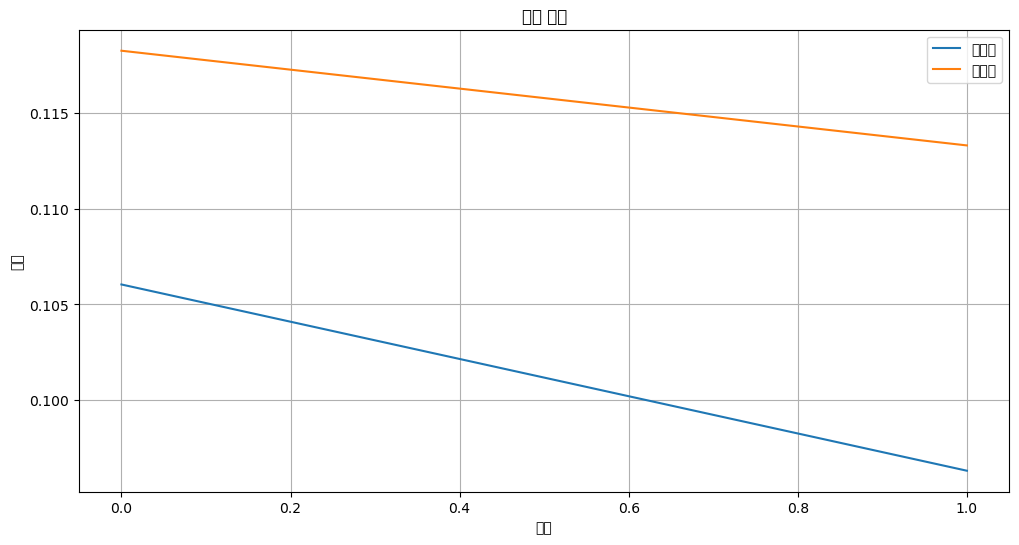

In [61]:
# 주가 예측
pred = model.predict(x_test) 

plt.figure(figsize=(12, 6))
plt.title('가격 예측')
plt.ylabel('평균')
plt.xlabel('일자')
plt.plot(y_test, label='실제값')
plt.plot(pred, label='예측값')
plt.grid()
plt.legend(loc='best')

plt.show()

In [63]:
#  모델을 평가한다
#  RMSE
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Train Score: %.2f RMSE' % (train_score))
print('Test Score: %.2f RMSE' % (test_score))
print('R2 :', r2_score(y_test, test_predict))


1/1 [==============================] - 0s 108ms/step
Train Score: 0.02 RMSE
Test Score: 0.02 RMSE
R2 : -14.141693325486841


In [593]:
# LSTM 모델 저장하기
model.save_weights('lstm_model_1')

In [594]:
load_model = Sequential()
load_model.add(LSTM(64, activation='tanh', #LSTM 레이어에서 tanh 를 활성화 함수로 가지는 노드 수 128개
               input_shape=x_train[0].shape)) #input_sape=(40, 2) 40개의 데이터를 2개씩 입력받음
load_model.add(Dropout(0.3)) #Dropout 레이어에서 30% 노드를 랜덤하게 제거
load_model.add(Dense(1, activation='linear'))

load_model.load_weights('lstm_model_hy')
load_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                17664     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# feature= candle_df[['시가', '고가', '저가','종가']]
# target= candle_df[['종가_shift']]

# # feature, target 데이터 스케일링
# scaler= MinMaxScaler()

# feature_sc= scaler.fit_transform(feature)
# target_sc= scaler.fit_transform(target)

# feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
# target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

# feature_sc
